In [20]:
%load_ext autoreload
%autoreload 2
from model import run_exp
import utils as utl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# set up

## environment

In [29]:
path_comp = './2023_03_23_completeness_630_final.csv'
path_con = './2023_03_23_connectivity_630_final.parquet'
path_res = './results/example/'

config = {
    'path_comp' : path_comp, 
    'path_con'  : path_con, 
    'path_res'  : path_res,
    'n_proc'    : 15,
    'n_trl'     : 15,
}

## custon neuron names

In [13]:
path_name = './flywire_ids_630.xlsx'

# sheet names of the xls file to include
sheets_pair = [ # pair of neurons (left+right per row)
    'stop',
    'walk',
    'walk_outputs',
    ]

sheets_single = [ # single neurons (one per row)
    # 'sugar', 
    # 'ovidn', 
    # 'bitter', 
    ]

name2flyid = utl.create_name_dict(path_name, path_comp, sheets_pair, sheets_single)

INFO: Loaded sheets ...
      ... stop
      ... walk
      ... walk_outputs

INFO: All names are unique

INFO: All IDs are unique

Declared 76 names for neurons

INFO: IDs appear to match with ./2023_03_23_completeness_630_final.csv



In [39]:
# lists of neuron groups
l_p9 = ['P9_l', 'P9_r'] 
l_bb = ['BB_r', 'BB_l']
l_cdn = ['P9-cDN1_l', 'P9-cDN1_r']

# run experiments

## P9 activation

In [31]:
instructions = [ 
    (0, 'stim', l_p9), 
    (1, 'end', [])
    ]

run_exp(exp_name='P9', exp_inst=instructions, name2flyid=name2flyid, **config)

INFO: results\example\P9.parquet will be overwritten
>>> Experiment:     P9
    Output files:   results\example\P9.parquet
                    results\example\P9.pickle
    Instructions:
           0 |  stim | P9_l P9_r
           1 |   end | 
    Elapsed time:   33 s


## P9 + BB

In [32]:
instructions = [ 
    (0, 'stim', l_p9), 
    (0.25, 'stim', l_bb),
    (0.75, 'slnc', l_bb),
    (1, 'end', []),
    ]
run_exp(exp_name='P9+BB_slnc', exp_inst=instructions, name2flyid=name2flyid, **config)

INFO: results\example\P9+BB_slnc.parquet will be overwritten
>>> Experiment:     P9+BB_slnc
    Output files:   results\example\P9+BB_slnc.parquet
                    results\example\P9+BB_slnc.pickle
    Instructions:
         0.0 |  stim | P9_l P9_r
        0.25 |  stim | BB_r BB_l
        0.75 |  slnc | BB_r BB_l
         1.0 |   end | 
    Elapsed time:   33 s


## change model

In [ ]:
from model import default_params as params
from brian2 import Hz

params['r_poi'] = 250 * Hz

instructions = [ 
    (0, 'stim', l_p9), 
    (1, 'end', [])
    ]
run_exp(exp_name='P9_ultra', exp_inst=instructions, name2flyid=name2flyid, **config, params=params)

# Process results

In [66]:
ps = [
    './results/example/P9.parquet',
    './results/example/P9+BB_slnc.parquet',
]

df_spkt = utl.load_exps(ps)
df_rate, df_std = utl.get_rate(df_spkt, duration=1)

df_rate = utl.rename_index(df_rate, name2flyid)
df_std = utl.rename_index(df_std, name2flyid)

utl.save_xls(df_rate, './results/example/rate.xlsx')
utl.save_xls(df_std, './results/example/rate_std.xlsx')

INFO: saving 2 experiments to ./results/example/rate.xlsx
INFO: saving 2 experiments to ./results/example/rate_std.xlsx


## Raster plots

INFO: setting figsize to (18, 4)


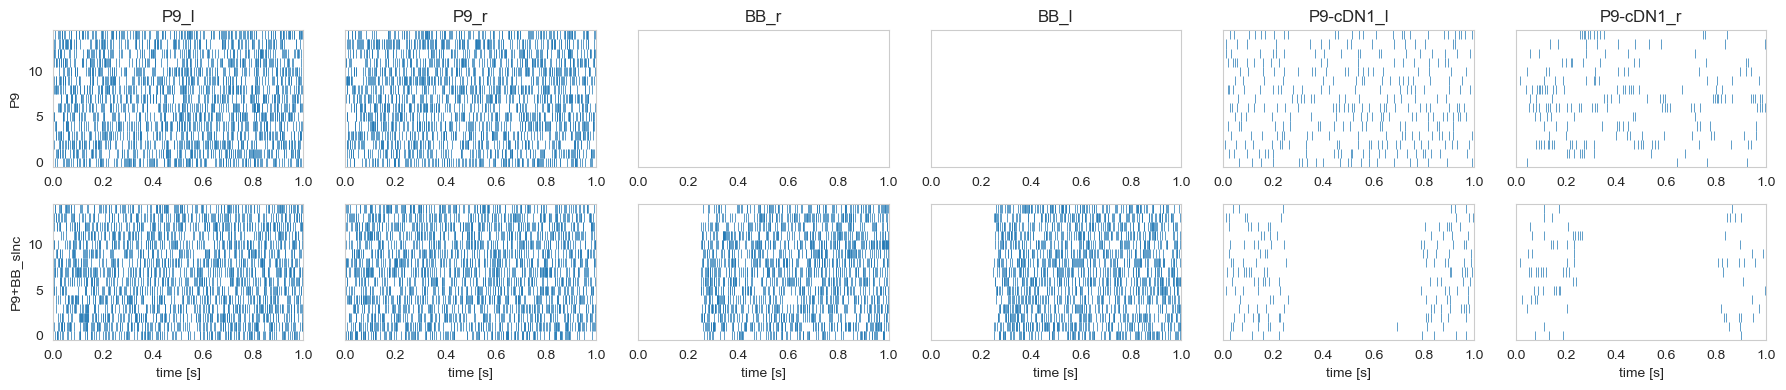

In [67]:
neu = l_p9 + l_bb + l_cdn
utl.plot_raster(df_spkt, neu, name2flyid=name2flyid, xlims=(0, 1))

## Firing rates

INFO: setting figsize to (10, 4)


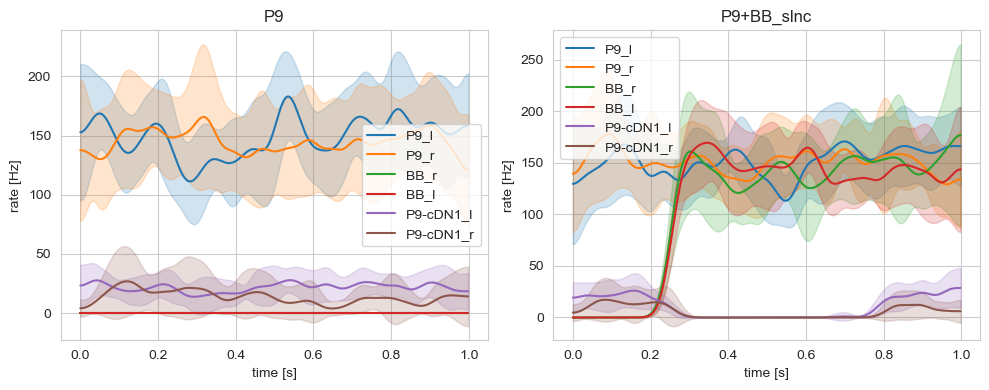

In [68]:
utl.plot_rate(df_spkt, neu, xlims=(0, 1), n_trl=15, name2flyid=name2flyid, sigma=25)

In [72]:
top20 = df_rate.sort_values(by='P9', ascending=False).head(20)
top20

exp_name,P9,P9+BB_slnc
flyid,,
P9_l,149.133333,150.666667
P9_r,144.733333,151.000000
720575940637718505,55.133333,55.866667
720575940619876884,49.400000,49.466667
720575940631924584,39.466667,41.000000
720575940632042148,36.466667,37.333333
720575940631283512,35.733333,36.066667
720575940623455239,32.000000,36.600000
DNa06_l,28.466667,17.733333


INFO: setting figsize to (10, 6.0)


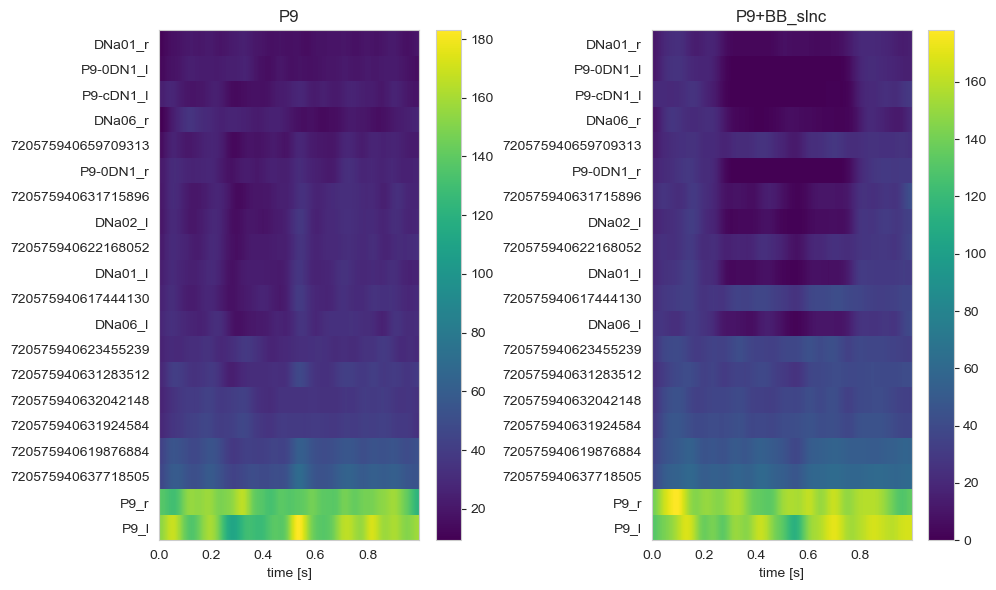

In [75]:
utl.plot_rate_heatmap(df_spkt, top20.index, xlims=(0, 1), n_trl=15, name2flyid=name2flyid)

# Graphs

In [77]:
# load connectome into graph
G = utl.get_full_graph(path_comp, path_con)
print(len(G.nodes))

127400


In [83]:
p = './results/example/P9.parquet'
utl.write_graph(G, p, name2flyid=name2flyid)


INFO: writing graph file results\example\P9.gexf
